### The following code can be used to reconstruct figure 4 **(c)**, (bottom row) in the paper.

In [1]:
import sys,os
sys.path.append('/Users/luigigresele/git/projects/ica_and_icm')

In [2]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from residual import TriangularResidual, ConstantScaling
from utils import get_config

from plotting import cart2pol 

from mixing_functions import build_moebius_transform, build_automorphism

### Get train/test data and parameters of the Möbius transformation

In [3]:
number_darmois = '0308'
model_root_darmois = '/Users/luigigresele/Desktop/ICA and ICM/Experiments_Vincent/'+ number_darmois +'/projects/ica-flows/experiments/triresflow/2d/'+ number_darmois +'/'

config_darmois = get_config(model_root_darmois + 'config/config.yaml')

In [4]:
S_train = jnp.array(jnp.load(model_root_darmois + 'data/sources_train.npy'))
S_test = jnp.array(jnp.load(model_root_darmois + 'data/sources_test.npy'))
X_train = jnp.array(jnp.load(model_root_darmois + 'data/observation_train.npy'))
X_test = jnp.array(jnp.load(model_root_darmois + 'data/observation_test.npy'))
mean_std = jnp.load(model_root_darmois + 'data/observation_mean_std.npy', allow_pickle=True).item()
mean_train, std_train = mean_std['mean'], mean_std['std']
moeb_params = jnp.load(model_root_darmois + 'data/moebius_transform_params.npy', allow_pickle=True).item()

### Specify how many datapoints to use for the plots and re-define the train/test splits accordingly

In [5]:
howmany = 5000

S_train = S_train[:howmany]
S_test = S_test[:howmany]
X_train = X_train[:howmany]
X_test = X_test[:howmany]

### Define the true mixing and unmixing, based on the parameters.

In [6]:
alpha = 1.0
A = jnp.array(moeb_params['A'])
a = jnp.array(moeb_params['a'])
b = jnp.zeros(2) 

mixing_moebius, mixing_moebius_inv = build_moebius_transform(alpha, A, a, b, epsilon=2)
mixing_batched = jax.vmap(mixing_moebius)

In [7]:
import matplotlib.pyplot as plt

In [8]:
import os

figure_path = "/Users/luigigresele/Documents/Plots_IMA"#/perceptually_uniform"

In [9]:
import numpy as np

In [10]:
from jax import vmap, jacfwd

In [11]:
from metrics import cima

### Plot $C_{\operatorname{IMA}}$ of the measure preserving automorphism composed on the right with the true unmixing, for different values of the rotation angle $\theta$ (takes roughly one minute on my laptop).

In [12]:
# Reconstruct observations by mixing the sources, since the observations are saved de-meaned.
S_test_mixed = vmap(mixing_moebius)(S_test)

In [13]:
angles = jnp.linspace(0, 360, num=720)
cimas_mpa = np.copy(angles)

for i, angle in enumerate(angles):
    # Build a rotation matrix
    theta = jnp.radians(angle)
    c, s = jnp.cos(theta), jnp.sin(theta)
    R = jnp.array([[c, -s], [s, c]])

    # Build measure pres. automorphism
    measure_preserving, measure_preserving_inv = build_automorphism(R)

    # Map the sources through **direct** mpa
    measure_preserving_batched = vmap(measure_preserving)
    Y = measure_preserving_batched(S_test)
    
    # Compose **its inverse** it with the mixing
    def composed_inverse_transformation(x):
        y = mixing_moebius_inv(x) + 0.5
        return measure_preserving(y)
    comp_inv_batched = jax.vmap(composed_inverse_transformation)
        
    # Compute the Jacobian
    Jcomposed = jacfwd(composed_inverse_transformation)
    Jcomposed_batched = vmap(Jcomposed)
    # Compute aDM true
    composed_cima = jnp.mean(cima(S_test_mixed, Jcomposed_batched))
    cimas_mpa[i] = composed_cima    

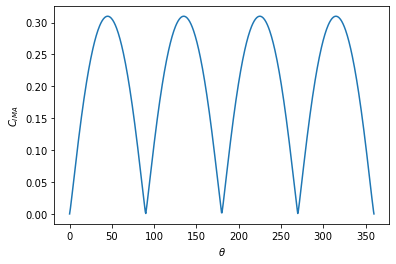

In [14]:
import matplotlib.pyplot as plt
plt.plot(angles, cimas_mpa)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$C_{IMA}$')
plt.show()

### Plot $C_{\operatorname{IMA}}$ of the measure preserving automorphism composed on the right with the **learnt Darmois construction**, for different values of the rotation angle $\theta$.

#### Load parameters of the trained Darmois construction

In [15]:
params_darmois = hk.data_structures.to_immutable_dict(jnp.load(model_root_darmois + 'checkpoints/model_100000.npy', allow_pickle=True).item())

In [16]:
# Setup model
n_layers_darmois = config_darmois['model']['flow_layers']
hidden_units_darmois = config_darmois['model']['nn_layers'] * [config_darmois['model']['nn_hidden_units']]

def inv_map_fn_darmois(x):
    flows = distrax.Chain([TriangularResidual(hidden_units_darmois + [2], name='residual_' + str(i))
                           for i in range(n_layers_darmois)] + [ConstantScaling(std_train)])
    return flows.inverse(x)

def fw_map_fn_darmois(x):
    flows = distrax.Chain([TriangularResidual(hidden_units_darmois + [2], name='residual_' + str(i))
                           for i in range(n_layers_darmois)] + [ConstantScaling(std_train)])
    return flows.forward(x)

fw_map_darmois = hk.transform(fw_map_fn_darmois)
inv_map_darmois = hk.transform(inv_map_fn_darmois)

In [17]:
inv_map_darmois_apply = lambda y: inv_map_darmois.apply(params_darmois, None, y)
jac_invmap = jax.vmap(jax.jacfwd(inv_map_darmois_apply))

In [18]:
import time

time_0 = time.time()

#### Set the number of angles to test. 
#### Figure in the paper is made with 720, which took $\sim 1$ hour on my laptop.

In [19]:
num = 13

In [20]:
angles = jnp.linspace(0, 360, num=num)
cimas = np.copy(angles)

start = np.copy(time_0)

for i, angle in enumerate(angles):
    # Build a rotation matrix
    theta = jnp.radians(angle)
    c, s = jnp.cos(theta), np.sin(theta)
    R = jnp.array([[c, -s], [s, c]])

    # Build measure pres. automorphism
    measure_preserving, measure_preserving_inv = build_automorphism(R)

# #     Map the sources through **direct** mpa
#     measure_preserving_batched = vmap(measure_preserving)
#     Y = measure_preserving_batched(S_rec_uni)

    
    # Compose **its inverse** it with the mixing
    def composed_inverse_transformation(x):
        y = inv_map_darmois_apply(x)
        y= jax.scipy.stats.norm.cdf(y)
        return measure_preserving(y)
    comp_inv_batched = vmap(composed_inverse_transformation)
    
    Y_1 = comp_inv_batched(X_test)
    
    # Compute the Jacobian
    Jcomposed = jacfwd(composed_inverse_transformation)
    Jcomposed_batched = vmap(Jcomposed)
    # Compute aDM true
    c_cima_ = cima(X_test, Jcomposed_batched)
    composed_cima = jnp.mean(c_cima_)
    cimas[i] = composed_cima
    if i%5==0:
        stop = time.time()
        print(i, "Duration:", stop - start, "; Total: ", stop - time_0)
        start = time.time()    

0 Duration: 4.914609909057617 ; Total:  4.914609909057617
5 Duration: 22.763267040252686 ; Total:  27.678053855895996
10 Duration: 23.762765169143677 ; Total:  51.440999031066895


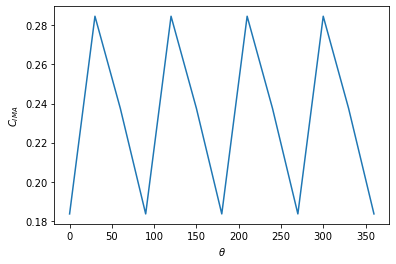

In [21]:
import matplotlib.pyplot as plt
plt.plot(angles, cimas)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$C_{IMA}$')
plt.show()

In [22]:
# np.save('cima_darmois_mpa_0308', cimas)#, fmt='%d')

#### Load the values here if already pre-computed.

In [23]:
loaded_angles = jnp.linspace(0, 360, num=720)
loaded_cimas = np.load('/Users/luigigresele/git/projects/ica_and_icm/cima_darmois_mpa_0308.npy')

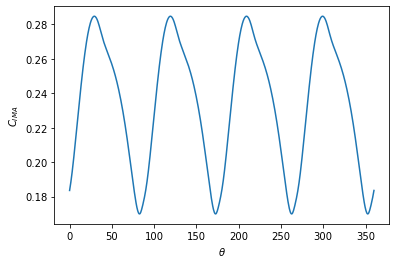

In [24]:
import matplotlib.pyplot as plt
plt.plot(loaded_angles, loaded_cimas)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$C_{IMA}$')
plt.show()

### Plot both together

In [25]:
angles_rad = np.radians(loaded_angles)

In [26]:
import os

In [27]:
figure_path = "/Users/luigigresele/Documents/Plots_IMA"

In [28]:
from matplotlib.ticker import FuncFormatter, MultipleLocator

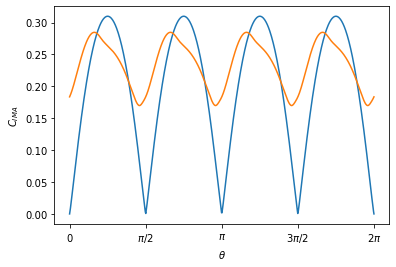

In [29]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(angles_rad, cimas_mpa, label='MPA')
ax.plot(angles_rad, loaded_cimas, label='Darmois+MPA')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$C_{IMA}$')

ax.set_xticks(np.arange(0, 2*np.pi+0.01, np.pi/2))
labels = ['$0$', r'$\pi/2$', r'$\pi$',
            r'$3\pi/2$', r'$2\pi$']
ax.set_xticklabels(labels)

# Uncomment if you want to save the figure

# plt.savefig(os.path.join(figure_path, 'mpa_darmois.pdf'), 
#             dpi=None, facecolor='w', edgecolor='w',
#             orientation='portrait', format=None,
#             transparent=True, bbox_inches='tight', pad_inches=0.1, metadata=None)

plt.show()